In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
import netCDF4 as nc
%matplotlib inline
plt.rcParams['text.usetex'] = False
plt.rcParams['mathtext.fontset'] = 'dejavuserif'
plt.rcParams['font.family'] = 'Dejavu Serif'

In [3]:
# constants
xIndices = [250,350]
yIndices = [250,350]

# io params
loc = "/scratch/hcm7920/"
saveloc = "/home/hcm7920/experiments/arcticMiddepthBI/plots/officialFigs/"
conc = ["0", "20", "40", "60", "80", "100"]

In [4]:
# load data
uVel = np.zeros(shape=(6,148,50,len(yIndices),len(xIndices)))
vVel = np.zeros(shape=(6,148,50,len(yIndices),len(xIndices)))
for ic in range(6):
  stateData = nc.Dataset(loc+f"amb{conc[ic]}/data/state.nc")
  uVel[ic,:,:,:,:] = stateData['U'][:,:,yIndices,xIndices]
  vVel[ic,:,:,:,:] = stateData['V'][:,:,yIndices,xIndices]
levs = stateData['Z'][:]


In [5]:
# calculate time mean KE
timeMeanKE = uVel.mean((1,))**2 + vVel.mean((1,))**2

# calculate eddy KE (not yet averaged in time)
eddyKE = (uVel-uVel.mean((1,))[:,None,:,:,:])**2
eddyKE +=(vVel-vVel.mean((1,))[:,None,:,:,:])**2

In [6]:
# average in time and calculate standard deviation
timeMeanEddyKE = eddyKE.mean((1,))
eddyKeStdDev = np.std(eddyKE,axis=1,ddof=1)

In [7]:
# add and subtract the standard dev
plusStddevEddyKE = timeMeanEddyKE + eddyKeStdDev
minusStddevEddyKE = timeMeanEddyKE - eddyKeStdDev

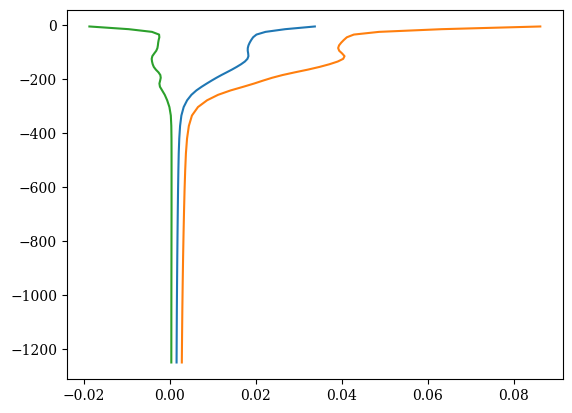

In [8]:
# plot a profile
iceIndex = 0
pairIndex = 0
deepIndex = 40
plt.plot(timeMeanEddyKE[iceIndex,:deepIndex,pairIndex,pairIndex],levs[:deepIndex])
plt.plot(plusStddevEddyKE[iceIndex,:deepIndex,pairIndex,pairIndex],levs[:deepIndex])
plt.plot(minusStddevEddyKE[iceIndex,:deepIndex,pairIndex,pairIndex],levs[:deepIndex])

In [14]:
# looks like i need to be more technical :/
# maybe as simple as: assume log-normal --> calculate std dev of logged values

# average in time, log the values, and calculate standard deviation
timeMeanEddyKELog = np.log(eddyKE).mean((1,))
eddyKeStdDevLog = np.std(np.log(eddyKE),axis=1,ddof=1)

# add and subtract the standard dev
plusStddevEddyKELog = timeMeanEddyKELog + eddyKeStdDevLog
minusStddevEddyKELog = timeMeanEddyKELog - eddyKeStdDevLog

# undo the log
plusStddevEddyKE = np.e**plusStddevEddyKELog
minusStddevEddyKE = np.e**minusStddevEddyKELog
timeMeanEddyKE = np.e**timeMeanEddyKELog

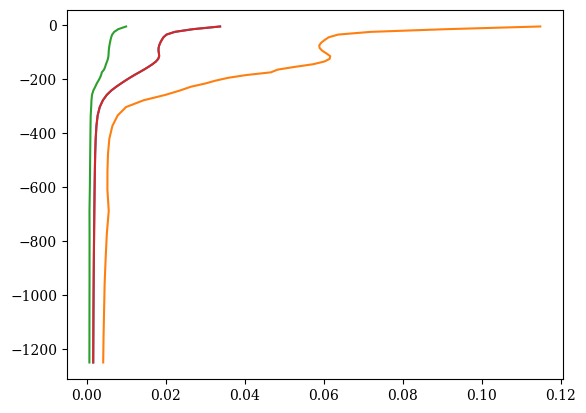

In [15]:
# plot a profile
iceIndex = 0
pairIndex = 0
deepIndex = 40
plt.plot(timeMeanEddyKE[iceIndex,:deepIndex,pairIndex,pairIndex],levs[:deepIndex])
plt.plot(plusStddevEddyKE[iceIndex,:deepIndex,pairIndex,pairIndex],levs[:deepIndex])
plt.plot(minusStddevEddyKE[iceIndex,:deepIndex,pairIndex,pairIndex],levs[:deepIndex])
plt.plot(eddyKE.mean((1,))[iceIndex,:deepIndex,pairIndex,pairIndex],levs[:deepIndex])

In [19]:
# or maybe we assume u and v are both normal
# and do math to calculate how quartiles change
# this is done through chi square distribution
# assuming u' is normalized to have stddev of 1
# if each u'^2 is a random variable, then numTimesteps*(u'^2).mean is chi squared
# use chi square pdf to get 0.1 and 0.9 vals for usquare statistics
# then divide by numTimesteps to get error bars
# and rescale by the factor used to get std dev of 1 initially